In [68]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

dateparse = lambda x: pd.datetime.strptime(x, '%d-%m-%Y %H')
# We select the columns for which we want to evaluate the density
colref = 'refugees_03_17'
colpop = 'pop_03_17'
### Output file name
output_densities_name = '/home/lorentz/Desktop/Datasets/D4R/densities_province_03_17.pkl'
output_figure_name = 'xxx.png'

### One file per time
# Depenting on the month for which we are evaluating the pop density
# we need to evaluate the phone call density
cdr_data_path = '/home/lorentz/Desktop/Datasets/D4R/Dataset1_Voice_New/Dataset 1_201703.txt'
sms_data_path = '/home/lorentz/Desktop/Datasets/D4R/Dataset1_SMS_New/Dataset 1_SMS_201703.txt'
base_station_location_path = '/home/lorentz/Desktop/Datasets/D4R/Base_Station_Location.txt'
overlap_shapefile = '/home/lorentz/Desktop/Datasets/D4R/overlap_file.shp'
groundtruth_data_path = '/home/lorentz/Desktop/Datasets/D4R/RefugeesTurkishPopulationGADM.csv'



In [69]:
### Load CDR data
cdr_data = pd.read_csv(cdr_data_path, encoding = 'utf-8', parse_dates=[0], date_parser=dateparse)
cdr_data = cdr_data[cdr_data.TIMESTAMP.apply(lambda x:x.hour>=20 or x.hour<=7)]
### Load SMS data
sms_data = pd.read_csv(sms_data_path, encoding = 'utf-8', parse_dates=[0], date_parser=dateparse)
sms_data = sms_data[sms_data.TIMESTAMP.apply(lambda x:x.hour>=20 or x.hour<=7)]
### Load base_station data
cell_location = pd.read_csv(base_station_location_path, encoding = 'utf-8', error_bad_lines=False)
### Load VORONOI overlap shapefile
shapefile = gpd.read_file(overlap_shapefile)
### Load GROUND TRUTH
groundtruth = pd.read_csv(groundtruth_data_path, encoding = 'utf-8')
groundtruth = groundtruth[['gadm_province',colref,colpop]].set_index('gadm_province')
groundtruth = groundtruth.drop(np.nan,axis=0,errors='ignore').sort_index()

In [70]:
### Check for tower duplicates and assign the same site id to the tower with the same coordinates
duplicates = cell_location.groupby(['MX_LAT1','MX_LAT2','MX_LAT3','MX_LONG1','MX_LONG2','MX_LONG3']).apply(lambda x:[(x.iloc[i]['BTS_ID'],x.iloc[0]['BTS_ID']) for i in range(len(x))] )
dizionario_duplicates = dict([item for sublist in duplicates.values for item in sublist])

cdr_data['INCOMING_SITE_ID'] = cdr_data['INCOMING_SITE_ID'].map(dizionario_duplicates)
cdr_data['OUTGOING_SITE_ID'] = cdr_data['OUTGOING_SITE_ID'].map(dizionario_duplicates)
sms_data['INCOMING_SITE_ID'] = sms_data['INCOMING_SITE_ID'].map(dizionario_duplicates)
sms_data['OUTGOING_SITE_ID'] = sms_data['OUTGOING_SITE_ID'].map(dizionario_duplicates)

In [71]:
### Build a dataframe "df_sigma_c" that contains the call/sms density for the different province/district (polygons)
# _t stands for turk data and _r for refugee data
# Here we assume that the refugee are not taken into account in the turk population numbers
### !!! Since we want a model that is scalable to different time granularity, e.g., months/days,
### !!! we average on the interval instead of just summing!!!
incoming_calls_t = cdr_data.groupby(['INCOMING_SITE_ID'])['NUMBER_OF_CALLS'].mean()-\
                   cdr_data.groupby(['INCOMING_SITE_ID'])['NUMBER_OF_REFUGEE_CALLS'].mean()
outgoing_calls_t = cdr_data.groupby(['OUTGOING_SITE_ID'])['NUMBER_OF_CALLS'].mean()-\
                   cdr_data.groupby(['OUTGOING_SITE_ID'])['NUMBER_OF_REFUGEE_CALLS'].mean()
incoming_sms_t = sms_data.groupby(['INCOMING_SITE_ID'])['NUMBER_OF_SMS'].mean()-\
                 sms_data.groupby(['INCOMING_SITE_ID'])['NUMBER_OF_REFUGEE_SMS'].mean()
outgoing_sms_t = sms_data.groupby(['OUTGOING_SITE_ID'])['NUMBER_OF_SMS'].mean()-\
                 sms_data.groupby(['OUTGOING_SITE_ID'])['NUMBER_OF_REFUGEE_SMS'].mean()

incoming_calls_r = cdr_data.groupby(['INCOMING_SITE_ID'])['NUMBER_OF_REFUGEE_CALLS'].mean()
outgoing_calls_r = cdr_data.groupby(['OUTGOING_SITE_ID'])['NUMBER_OF_REFUGEE_CALLS'].mean()
incoming_sms_r = sms_data.groupby(['INCOMING_SITE_ID'])['NUMBER_OF_REFUGEE_SMS'].mean()
outgoing_sms_r = sms_data.groupby(['OUTGOING_SITE_ID'])['NUMBER_OF_REFUGEE_SMS'].mean()

new_df = pd.concat([incoming_calls_t, outgoing_calls_t,incoming_sms_t,outgoing_sms_t,
                    incoming_calls_r, outgoing_calls_r,incoming_sms_r,outgoing_sms_r],
                   axis = 1).fillna(0)
new_df.columns =  ['calls_incoming_t','calls_outgoing_t','sms_incoming_t','sms_outgoing_t',
                     'calls_incoming_r','calls_outgoing_r','sms_incoming_r','sms_outgoing_r']
dict_calls = new_df.to_dict()

for key in dict_calls.keys():
    shapefile[key] = shapefile['BTS_ID'].map(dict_calls[key])
shapefile = shapefile.fillna(0)

### Evaluationg sigma_c for each polygon (SITE) both for turkish and refugee
shapefile['calls_incoming_density_t'] = shapefile['area_fract']*shapefile['calls_incoming_t']/shapefile['area_voron']
shapefile['sms_incoming_density_t'] = shapefile['area_fract']*shapefile['sms_incoming_t']/shapefile['area_voron']
shapefile['calls_outgoing_density_t'] = shapefile['area_fract']*shapefile['calls_outgoing_t']/shapefile['area_voron']
shapefile['sms_outgoing_density_t'] = shapefile['area_fract']*shapefile['sms_outgoing_t']/shapefile['area_voron']

shapefile['calls_incoming_density_r'] = shapefile['area_fract']*shapefile['calls_incoming_r']/shapefile['area_voron']
shapefile['sms_incoming_density_r'] = shapefile['area_fract']*shapefile['sms_incoming_r']/shapefile['area_voron']
shapefile['calls_outgoing_density_r'] = shapefile['area_fract']*shapefile['calls_outgoing_r']/shapefile['area_voron']
shapefile['sms_outgoing_density_r'] = shapefile['area_fract']*shapefile['sms_outgoing_r']/shapefile['area_voron']

df_sigma_c = shapefile.groupby('NAME_1')[['calls_incoming_density_t','sms_incoming_density_t',
                                          'calls_outgoing_density_t','sms_outgoing_density_t',
                                          'calls_incoming_density_r','sms_incoming_density_r',
                                          'calls_outgoing_density_r','sms_outgoing_density_r','area']].sum()

df_sigma_c = df_sigma_c.sort_index()

In [73]:
### Concatenation of population densities and mobile phone activity dentisies
# Export the dataframe containing the densities
res = pd.concat([df_sigma_c, groundtruth],axis = 1)
res['pop_density_r'] = res[colref]/res['area']
res['pop_density_t'] = res[colpop]/res['area']
res = res.fillna(0)
#res = res[(res.call_density>0) & (res.pop_density>0)]
res.to_pickle(output_densities_name)

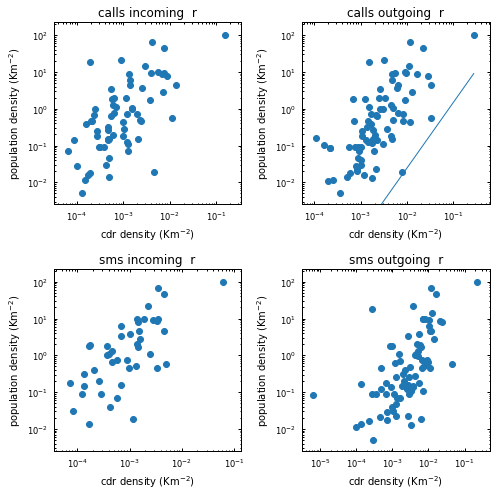

In [74]:
def setup_mpl():
    mpl.rc('font', size=10)
    mpl.rcParams['legend.fontsize'] = 'small'
    mpl.rcParams['legend.fontsize'] = 'small'
    mpl.rcParams['xtick.labelsize'] = 'small'
    mpl.rcParams['ytick.labelsize'] = 'small'
    mpl.rcParams['font.family']='Arial'
    mpl.rcParams['xtick.major.pad']='6'
    mpl.rcParams['ytick.major.pad']='6'
    mpl.rcParams['lines.linewidth'] = 1
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.minor.width'] = 1
    mpl.rcParams['xtick.major.size'] = 3
    mpl.rcParams['ytick.major.size'] = 3
    mpl.rcParams['xtick.minor.size'] = 1.5
    mpl.rcParams['ytick.minor.size'] = 1.5
    mpl.rcParams['axes.linewidth'] = 1
    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.top']=True
    mpl.rcParams['ytick.right']=True
    mpl.rcParams['mathtext.default']='regular'


setup_mpl()

fig,ax = plt.subplots(2,2,figsize=(7,7))
axes = list(ax.flatten())
i=1
for a,column in zip(axes,['calls_incoming_density_r','calls_outgoing_density_r','sms_incoming_density_r','sms_outgoing_density_r']):
    a.set_title(column.replace('density','').replace('_',' '))
    a.scatter(res[column].values,res.pop_density_r.values)
    if i==2:
        xticks = np.logspace(np.log10(res[res[column]!=0][column].values.min()),np.log10(res[column].values.max()))
        yval = alpha_r*xticks**beta_r
        a.plot(xticks,yval)
    i+=1
    a.set_yscale('log')
    a.set_xscale('log')
    a.set_ylim(min(res.pop_density_r[res.pop_density_r>0]*0.5), max(res.pop_density_r[res.pop_density_r>0]*2.2))
    a.set_xlim(min(res[column][res[column]>0]*0.5), max(res[column][res[column]>0]*2.2))
    a.set_ylabel(r'population density ($Km^{-2}$)')
    a.set_xlabel(r'cdr density ($Km^{-2}$)')
fig.tight_layout()
plt.savefig(output_figure_name,bbox_inches = 'tight')

In [62]:
alpha_r = 88.3 #+-1.1
beta_r = 1.78 #+-0.03

xticks = np.logspace(res[column].values.min(),res[column].values.max())
yval = alpha_r*xticks**beta_r

array([1.00000000e+00, 1.34928788e+00, 1.82057778e+00, 2.45648353e+00,
       3.31450346e+00, 4.47221934e+00, 6.03431136e+00, 8.14202317e+00,
       1.09859332e+01, 1.48231865e+01, 2.00007459e+01, 2.69867640e+01,
       3.64129136e+01, 4.91315029e+01, 6.62925414e+01, 8.94477226e+01,
       1.20690728e+02, 1.62846536e+02, 2.19726858e+02, 2.96474786e+02,
       4.00029835e+02, 5.39755408e+02, 7.28285430e+02, 9.82666704e+02,
       1.32590027e+03, 1.78902117e+03, 2.41390458e+03, 3.25705219e+03,
       4.39470104e+03, 5.92971685e+03, 8.00089508e+03, 1.07955108e+04,
       1.45662518e+04, 1.96540670e+04, 2.65189944e+04, 3.57817577e+04,
       4.82798920e+04, 6.51434731e+04, 8.78972987e+04, 1.18598760e+05,
       1.60023869e+05, 2.15918267e+05, 2.91335901e+05, 3.93096000e+05,
       5.30399668e+05, 7.15661843e+05, 9.65633851e+05, 1.30291805e+06,
       1.75801153e+06, 2.37206366e+06])